## **Exercise 2: Random Loss in the Dike Construction Problem**

Consider the **random loss version** of the **Dike Construction Problem (DCP-randomloss)** as illustrated in the lecture. We repeat the problem setting below:

- The **investment cost** of the dike is proportional to its height, with a constant **$c = 0.9$** [M€/m/yr].
- The **height of the dike** $x$ can take any value in the range **$[0,3]$** meters, where **$x = 0$** means no dike is constructed.
- The **economic loss** of the power plant from a flooding event is **proportional to the overflow height**, with a **random coefficient** $a$ [M€/m/yr] following a **lognormal distribution**:

  $$
  a \sim \mathrm{Lognormal}(0.7, 0.16^2)
  $$

- The **historical annual maximum overflow height** $H$ (when no dike was present) follows a **Gamma distribution**:

  $$
  H \sim \mathrm{Gamma}(\alpha= 8, \beta=4.5)
  $$

### **Task**
1. Use **Monte Carlo sampling** to simulate the **distribution of historical annual economic losses** from flooding events.
2. Calculate the **empirical VaR and CVaR** of these losses at a **confidence level** $\alpha = 0.9$.

### **Probability Density Functions**
- The **PDF of $H$** (Gamma-distributed) is:

  $$
  f_H(x) = \frac{\beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)}
  $$

- The **PDF of $a$** (Lognormal-distributed) is:

  $$
  f_a(x) = \frac{1}{x} \cdot \frac{1}{\sigma \sqrt{2\pi}} \exp \left( - \frac{(\ln x - \mu)^2}{2\sigma^2} \right)
  $$



In [30]:
#!apt-get install -y coinor-cbc # for colab

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from matplotlib import rc
from scipy.optimize import linprog
import pyomo.environ as pyo
from pyomo.environ import SolverFactory

#solver = SolverFactory('cbc', executable='/usr/bin/cbc') # for colab

rc('text', usetex=True) # If you wanna print latex on the graphs


rc('text', usetex=True)

## **Task 1: Monte Carlo Sampling**

Please complete the generation of the sampled data:

- **`H_rnd`** ($H_i$): Random samples of the historical annual maximum overflow height, $H$, using the given Gamma distribution parameters.
- **`a_rnd`** ($a_i$): Random samples of the economic loss coefficient, $a$, using the given Lognormal distribution parameters.

Use the provided parameters and set the **sample size** to `msize`.


**Step 1: Define Parameters and Generate Random Samples**

What to do in the next code cell:

Define the parameters of the Gamma and Lognormal distributions.

Use Monte Carlo sampling to generate random values of overflow height (H_rnd) and economic loss coefficient (a_rnd).

In [31]:
# Step 1: Define parameters for the distributions
msize = 100000  # Sample size for Monte Carlo simulation
shape = 8  # Shape parameter (α) for the Gamma distribution (to avoid confusion with α quantile)
beta = 4.5  # Scale parameter (β) for the Gamma distribution
mu = 0.7  # Mean of the Lognormal distribution (in log-space)
sigma = 0.16  # Standard deviation of the Lognormal distribution (in log-space)

# Step 1: Generate random samples
H_rnd = stat.gamma.rvs(shape, scale=1/beta, size=msize)  # Gamma-distributed samples (H)
a_rnd = stat.lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=msize)  # Lognormal-distributed samples (a)

# Print the first 5 values of each sample set to verify the results
print("First 5 values of H_rnd (overflow height):", H_rnd[:5])
print("First 5 values of a_rnd (economic loss coefficient):", a_rnd[:5])

First 5 values of H_rnd (overflow height): [2.25 2.02 2.28 2.88 1.59]
First 5 values of a_rnd (economic loss coefficient): [1.95 2.2  1.8  2.01 1.73]


**Step 2: Compare with a Normal Distribution**

- Generate a normally distributed dataset (arnd_norm) with the same mean and variance as a_rnd

- Comparison between the lognormal and normal distributions

In [32]:
# Step 2: Generate normal-distributed data for comparison
arnd_norm = stat.norm.rvs(loc=2, scale=0.31, size=msize)  # Normal-distributed samples

# Print the first 5 values to verify
print("First 5 values of arnd_norm (normal distribution):", arnd_norm[:5])

First 5 values of arnd_norm (normal distribution): [2.22 2.09 1.88 1.92 1.75]


**Step 3: Plot Histograms of the Sampled Data**

- Plot histograms for H_rnd (Gamma) and a_rnd (Lognormal)

- Compare a_rnd with arnd_norm (Normal) in the second plot

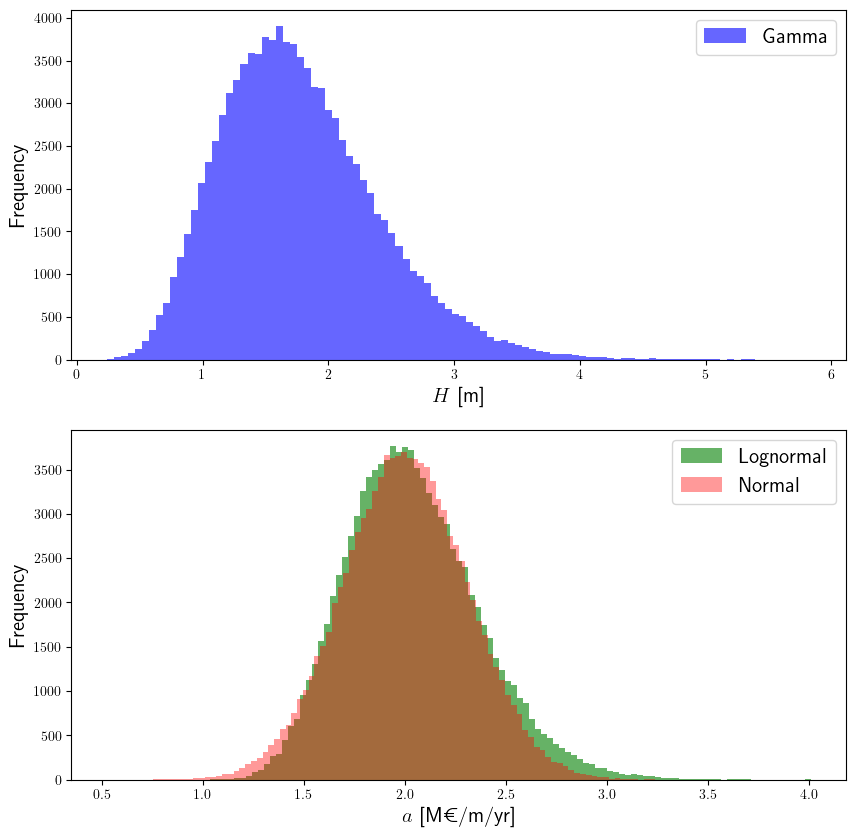

In [33]:
# Step 3: Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# Plot histogram of H_rnd (Gamma distribution)
ax[0].hist(H_rnd, bins=100, facecolor='b', alpha=0.6, label='Gamma')
ax[0].set_xlabel(r'$H$ [m]', fontsize=15)
ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].legend(fontsize=15)

# Plot histogram of a_rnd (Lognormal distribution) and arnd_norm (Normal distribution)
ax[1].hist(a_rnd, bins=100, facecolor='g', alpha=0.6, label='Lognormal')
ax[1].hist(arnd_norm, bins=100, facecolor='r', alpha=0.4, label='Normal')
ax[1].set_xlabel(r'$a$ [M\texteuro/m/yr]', fontsize=15)
ax[1].set_ylabel('Frequency', fontsize=15)
ax[1].legend(fontsize=15)

# Show the plots
plt.show()

## **Task 2: Compute Risk Measures (VaR & CVaR)**

1. Complete the function **`risk_calculation`** to compute the **economic loss** and risk measures for the given sampled data:

- **Inputs:**
  - `H_rnd` ($H_i$): Simulated samples of the historical overflow height.
  - `a_rnd` ($a_i$): Simulated samples of the economic loss coefficient.
  - `alpha` ($\alpha$): Confidence level for risk calculations.

- **Outputs:**
  - `loss`: A vector containing the **economic loss** computed from $H_i$ and $a_i$.
  - `var` ($\mathrm{VaR}_\alpha$): The **Value at Risk** at confidence level $\alpha$.
  - `cvar` ($\mathrm{CVaR}_\alpha$): The **Conditional Value at Risk** at confidence level $\alpha$.

2. Compute and plot


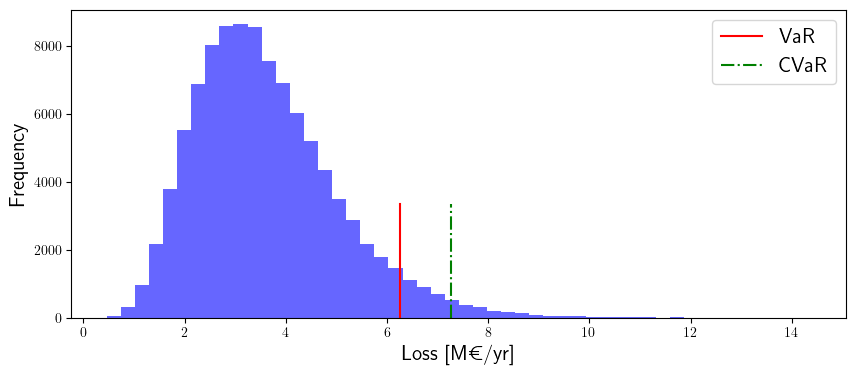

Expected loss is 3.6173
95.0% VaR is 6.2601
95.0% CVaR is 7.2554


In [34]:
# Set confidence level for risk calculations
alpha = 0.95  # 95% confidence level for VaR and CVaR
binsize = 50

# Function to compute economic loss, VaR, and CVaR
def risk_calculation(H_rnd, a_rnd, alpha):
    """
    Computes the economic loss and risk measures (VaR and CVaR) for given sampled data.
    
    Parameters:
    - H_rnd (array): Simulated samples of historical overflow height.
    - a_rnd (array): Simulated samples of the economic loss coefficient.
    - alpha (float): Confidence level for risk calculations (e.g., 0.95 for 95% confidence).

    Returns:
    - loss (array): Economic loss values calculated as H * a.
    - var (float): Value at Risk (VaR) at confidence level alpha.
    - cvar (float): Conditional Value at Risk (CVaR) at confidence level alpha.
    """
    loss = np.multiply(H_rnd, a_rnd)  # Compute economic loss as H * a
    
    # Compute empirical Value at Risk (VaR) as the alpha-quantile of the loss distribution
    var = np.quantile(loss, alpha, method='higher')

    # Compute Conditional Value at Risk (CVaR) as the mean loss above VaR
    cvar = loss[loss >= var].mean()

    return loss, var, cvar

# Compute loss, VaR, and CVaR using Monte Carlo samples
loss, var, cvar = risk_calculation(H_rnd, a_rnd, alpha)

# --------------------------- Visualization --------------------------- #

# Create a figure for the histogram of economic loss
fig, ax = plt.subplots(figsize=(10, 4))

# Plot histogram of the loss distribution
ax.hist(loss, bins=binsize, facecolor='b', alpha=0.6)

# Set labels for the axes
ax.set_xlabel(r'Loss [M\texteuro/yr]', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)

# Mark VaR with a vertical red line
ax.plot(var * np.ones((2, 1)), (0, msize / 30), 'r', label='VaR')

# Mark CVaR with a vertical green dashed line
ax.plot(cvar * np.ones((2, 1)), (0, msize / 30), '-.g', label='CVaR')

# Add legend to the plot
ax.legend(fontsize=15)

# Display the plot
plt.show()

# --------------------------- Display Results --------------------------- #

# Set NumPy print options for better readability (2 decimal places)
np.set_printoptions(precision=2)

# Print the expected (mean) economic loss
print("Expected loss is", '%.4f' % np.mean(loss))

# Print the calculated VaR at the given confidence level
print(str(alpha * 100) + "% VaR is", '%.4f' % var)

# Print the calculated CVaR at the given confidence level
print(str(alpha * 100) + "% CVaR is", '%.4f' % cvar)


---

### **Part 2: Optimal Dike Height Selection**
Now, assume that the **goal is to determine the optimal dike height** $x$ that minimizes the **total expected cost**, which consists of:
- The **investment cost** of constructing the dike.
- The **expected economic loss** due to flooding.

#### **Tasks**
1. **Formulate the Sample Average Approximation (SAA) problem**:  
   - Express the total expected cost as a function of the dike height $x$.
   - Use the Monte Carlo estimates to approximate this expectation.
   
2. **Solve for the optimal dike height** $x^*$ that minimizes the total expected cost.

---

## **Stochastic Optimization Problem (SO)**

The **stochastic optimization (SO) problem** for the dike construction is formulated as follows:

$$
\begin{aligned}
& \underset{x}{\text{minimize}}  &\quad & C(x) = 0.9x+ \mathbb{E} [a(H - x)_+]\\
&\text{subject to} &  & 0 \leq x \leq 3 
\end{aligned}
$$

### **Sample Average Approximation (SAA)**

In the **Sample Average Approximation (SAA)** method, we generate a set of **$N$ independent samples** of the random variables $a$ and $H$, i.e., $(a_i, H_i)$ for $i=1,...,N$, based on their given probability distributions. The corresponding **SAA problem** becomes:

$$
\begin{aligned}
& \underset{x}{\text{minimize}} &\quad & C_N(x) = 0.9x + \frac{1}{N} \sum_{i=1}^{N}\left\lbrace a_i(H_i-x)_{+} \right\rbrace \\
&\text{subject to} & & 0 \leq x \leq 3 
\end{aligned}
$$

### **Linear Programming (LP) Reformulation**

The problem can be transformed into a **linear program (LP)** by introducing an **auxiliary variable** $h_i$ for **$(H_i - x)_+$**, leading to:

$$
\begin{aligned}
& \underset{x \in [0,3]}{\text{minimize}}  &\quad & C_N(x) = 0.9x+\frac{1}{N} \sum_{i=1}^{N} a_ih_i\\
&\text{subject to} &  & h_i \geq 0 \quad \forall i=1,...,N  \\  
&                  &  & h_i \geq (H_i-x) \quad \forall i=1,...,N 
\end{aligned}
$$


**Step 1: Solve the SAA Problem Using Linear Programming (SciPy)**

Implement the function dcp_saa_linprog(a, H, N) to solve the Sample Average Approximation (SAA) problem using SciPy's linear programming solver (linprog)

In [35]:
def dcp_saa_linprog(a, H, N):
    """
    Solves the dike construction problem using linear programming (SciPy).

    Parameters:
    - a (array): Economic loss coefficients (size N).
    - H (array): Historical annual maximum overflow heights (size N).
    - N (int): Number of samples.

    Returns:
    - res (OptimizeResult): Solution of the LP problem.
    """

    # Define variable bounds
    xbounds = (0, 3)  # x can take values in [0,3]
    hbounds = [(0, None) for i in range(N)]  # h_i ≥ 0 for all i

    # Combine x and h bounds
    bds = hbounds
    bds.insert(0, xbounds)    

    # Define objective function coefficients (c vector)
    c = np.append(0.9, a/N)  # 0.9x + (1/N) * sum(a_i * h_i)

    # Define inequality constraints (Ax ≤ b)
    A = np.concatenate((np.c_[-np.ones(N)], np.diag(-np.ones(N))), axis=1)  # h_i + x ≥ H_i → -x - h_i ≤ -H_i
    b = -H  # Right-hand side of inequality constraints

    # Solve LP using the 'revised simplex' method
    res = linprog(c, A_ub=A, b_ub=b, bounds=bds, method='revised simplex')

    return res



**Step 2: Solve the SAA Problem Using Pyomo**

Implement the function dcp_saa_pyomo(a, H, solver) to solve the SAA problem using Pyomo, which provides more flexibility for complex models.

In [36]:
def dcp_saa_pyomo(a, H, solver):
    """
    Solves the dike construction problem using Pyomo (LP formulation).

    Parameters:
    - a (array): Economic loss coefficients (size N).
    - H (array): Historical annual maximum overflow heights (size N).
    - solver (str): Name of the solver to use (e.g., 'cbc').

    Returns:
    - x.value (float): Optimal dike height.
    - model.totalCost() (float): Expected total cost at optimal x.
    """

    N = len(H)  # Number of samples
    I = range(N)  # Index set for samples

    # Define Pyomo model
    model = pyo.ConcreteModel()

    # Define decision variables
    model.x = pyo.Var(domain=pyo.NonNegativeReals)  # x is the dike height (≥ 0)
    model.h = pyo.Var(I)  # h_i variables for overflow loss

    # Add constraints
    model.constraints = pyo.ConstraintList()
    model.constraints.add(model.x <= 3)  # 0 ≤ x ≤ 3
    for i in I:
        model.constraints.add(model.h[i] >= 0)  # h_i ≥ 0
        model.constraints.add(model.h[i] + model.x >= H[i])  # h_i ≥ H_i - x

    # Define objective function
    model.totalCost = pyo.Objective(expr=0.9 * model.x + (1 / N) * sum(a[i] * model.h[i] for i in I), sense=pyo.minimize)

    # Solve using the specified solver
    solver = pyo.SolverFactory(solver)
    solver.solve(model)

    return model.x.value, model.totalCost()



**Step 3: Generate Sample Data and Solve the Problem**

- Generate random samples for H (Gamma) and a (Lognormal)

- Solve the problem using dcp_saa_pyomo with solver 'cbc'

- Print the optimal dike height and expected cost

In [38]:
# Set the sample size
nsize = 1000

# Generate sample data for overflow height H (Gamma distribution)
H = stat.gamma.rvs(shape, scale=1/4.5, size=nsize)

# Generate sample data for economic loss coefficient a (Lognormal distribution)
a = stat.lognorm.rvs(0.16, loc=0, scale=np.exp(0.7), size=nsize)

# Solve using Pyomo with solver 'cbc'
x, obj = dcp_saa_pyomo(a, H, 'cbc')

# Print results
print('Optimal dike height: ', x)
print('Expected total cost: ', obj)


Optimal dike height:  1.8206594
Expected total cost:  2.1172661433729503


## **Part 3: Solve the SAA Problem with Different Sample Sizes**

To assess the impact of sample size on the **SAA solution**, we follow five key steps:

### **1️ Solve the SAA Problem for Different Sample Sizes**
- Run the **Sample Average Approximation (SAA) optimization** using various Monte Carlo sample sizes.
- Compute the **optimal dike height \( x^* \)** and **expected total cost** for each sample size.

### **2 Compare the Results Across Sample Sizes**
- Observe how the **optimal height and total cost change** as `nsize` increases.
- Determine if the solution stabilizes with **larger sample sizes**.

### **3️ Perform Out-of-Sample Validation**
- Use an **independent validation dataset** to test the robustness of the obtained solutions.
- Evaluate whether the results remain consistent or fluctuate significantly.

### **4️ Compute the True Expected Cost Function**
- Compare the **estimated cost function** (from Monte Carlo sampling) with the **analytical expected cost function**.
- Check if the **sample-based cost function approximates the true cost**.

### **5️ Assess the Optimality Gap**
- Run the **SAA problem multiple times** to evaluate the variability of the solution.
- Compute **confidence bounds (LB and UB)** to quantify the **uncertainty in the optimal solution**.


---

### **Key Questions to Consider**
- Does the optimal solution **converge** as `nsize` increases?
- How much **variation** do you observe in the results with different `nsize` values?
- What is a **reasonable choice** of `nsize` to ensure accurate results while keeping computation time manageable?
- How close are the **estimated** and **true expected cost functions**?
- What is the **uncertainty (gap) between the estimated and best solutions**?

---

**Step 1: Solve the SAA Problem for Different Sample Sizes**

- Generate Monte Carlo samples for different values of nsize
- Solve the SAA problem using Pyomo
- Print the optimal dike height and expected total cost for each sample size

In [ ]:
# Define different sample sizes to test
nsize = [20, 200, 2000]  # Different sizes of training samples

# Lists to store results
Hrnd = []  # Overflow height samples (Gamma-distributed)
arnd = []  # Economic loss coefficient samples (Lognormal-distributed)

# Generate Monte Carlo samples for different sizes
for i in range(len(nsize)):
    H = stat.gamma.rvs(shape, scale=1/beta, size=nsize[i])  # Generate Gamma samples
    a = stat.lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=nsize[i])  # Generate Lognormal samples
    Hrnd.append(H)
    arnd.append(a)

# Solve the SAA problem for each sample size
res = []
for i in range(len(nsize)):
    res.append(dcp_saa_pyomo(arnd[i], Hrnd[i], 'cbc'))  # Solve using Pyomo
    print("SAA with sample size", nsize[i], "result: x =", res[i][0])
    print('The minimal expected total cost =', res[i][1])

**Step 2: Validate the Results Using Out-of-Sample Data**

- Define the validation function dcp_validate(), which evaluates the out-of-sample expected cost for a given dike height

- Compute the training and validation costs for each sample size

In [ ]:
def dcp_validate(x, vali_a, vali_H):
    """
    Computes the expected total cost for a given dike height x using out-of-sample data.

    Parameters:
    - x (float): Optimal dike height obtained from training.
    - vali_a (array): Economic loss coefficient samples (validation set).
    - vali_H (array): Overflow height samples (validation set).

    Returns:
    - cmean (float): Expected total cost using the given x.
    - c (array): Total cost distribution over validation samples.
    """
    if len(vali_a) != len(vali_H):
        return -1  # Error case: mismatched sample sizes

    M = len(vali_a)  # Number of validation samples
    c = 0.9*x + np.multiply(vali_a, np.maximum(0, [h - x for h in vali_H]))  # Compute total cost
    cmean = c.mean()  # Compute expected cost

    return cmean, c

# Lists to store training and validation costs
trngCost = []
valiObj = []
valiCost = []

# Use the same validation set for all cases
arnd_vali = a_rnd  # Out-of-sample economic loss coefficients
Hrnd_vali = H_rnd  # Out-of-sample overflow heights

# Compute training and validation costs for each sample size
for i in range(len(nsize)): 
    # Compute total cost on training set
    _, trngCost_tmp = dcp_validate(res[i][0], np.array(arnd[i]), np.array(Hrnd[i]))
    trngCost.append(trngCost_tmp)

    # Compute total cost on validation set
    valiObj_tmp, valiCost_tmp = dcp_validate(res[i][0], np.array(arnd_vali), np.array(Hrnd_vali))
    valiObj.append(valiObj_tmp)
    valiCost.append(valiCost_tmp)


**Step 3: Visualize the Cost Distribution for Training and Validation Sets**

- Plot histograms of the total cost distribution for both training and validation sets

- Compare mean costs for training vs. validation

In [ ]:
# Define histogram bin size
binsize = 50

# Create subplots for each sample size
fig, ax = plt.subplots(len(nsize), 1, figsize=(10, 4 * len(nsize)), sharex=True)

# Plot histograms of training and validation cost distributions
for i in range(len(nsize)):
    ax[i].hist(trngCost[i], bins=binsize, facecolor='b', alpha=0.8, label="Training set total cost")
    ax[i].hist(valiCost[i], bins=binsize, facecolor='r', alpha=0.2, label="Validation set total cost")

    # Mark the mean cost on training and validation sets
    ax[i].plot(res[i][1] * np.ones((2, 1)), (0, 10**4), 'b', label='Mean total cost (Training)')
    ax[i].plot(valiObj[i] * np.ones((2, 1)), (0, 10**4), 'r', label='Mean total cost (Validation)')

    ax[i].set_ylabel('Frequency', fontsize=15)
    ax[i].set_title('Optimal dike height = ' + str("{:.2f}".format(res[i][0])) + ' [m]', fontsize=15)
    ax[i].set_yscale('log')  # Log-scale for better visualization
    ax[i].set_xscale('log')  # Log-scale for better visualization
    ax[i].legend()

    if i == len(nsize) - 1:
        ax[i].set_xlabel(r'Total Cost [M\texteuro/yr]', fontsize=15)

# Save and display the figure
plt.savefig('dike_example.png')
plt.show()

## **Analytical Calculation of the Expected Total Cost**

For this simple problem, we can compute the **expected total cost** $\mathbb{E}[C(x)]$ analytically:

$$
\begin{aligned}
\mathbb{E}[C(x)] &= 0.9x + \mathbb{E}[a(H-x)_+] \\
                 &= 0.9x + \mathbb{E}[a] \cdot \left\{ \mathbb{E}[H-x|H\geq x] \cdot \mathbb{P}(H\geq x) + 0\cdot \mathbb{P}(H < x) \right\} \\
                 &= 0.9x + e^{\mu+ 0.5\cdot\sigma^2} \cdot \mathbb{E}[H-x|H\geq x] \cdot [1-F_{H}(x)]
\end{aligned}
$$

Thus, we can **compare the estimated expected cost function** (computed from each sampled model) with the **true expected cost function** to evaluate the accuracy of the stochastic approximation.


**Step 4: Compare Estimated and True Expected Cost Functions**

- Plot the estimated expected cost function for different sample sizes

- Compare them with the true expected cost function

In [ ]:
# Define x values for expected cost function
numx = 5000
x = np.linspace(0, 3.0, num=numx)
totCost = []

# Compute estimated expected cost function for each sample size
for i in range(len(nsize)):
    h = np.tile(np.array([Hrnd[i]]).T, (1, numx)) - x
    h = h.clip(min=0)
    tc = 0.9*x + 1/nsize[i]*np.sum(np.multiply(h, np.tile(np.array([arnd[i]]).T, (1, numx))), axis=0)
    totCost.append(tc)

# Compute the true expected cost function
H_cond_expect = np.zeros(numx)
for i in range(numx):
    H_cond_expect[i] = stat.gamma.expect(lambda h: h - x[i], args=(shape,), scale=1/beta, lb=x[i], conditional=True)

trueCost = 0.9*x + np.exp(mu + 0.5*sigma**2) * np.multiply(H_cond_expect, (1 - stat.gamma.cdf(x, shape, scale=1/beta)))

# Plot estimated vs. true cost functions
fig, ax = plt.subplots(figsize=(8, 5))
linespec = [':b', '-.g', '--r']
for i in range(len(nsize)):
    plt.plot(x, totCost[i], linespec[i], linewidth=2, label='Sample size N=' + str(nsize[i]))
plt.plot(x, trueCost, 'k', linewidth=1, label='True expected cost function')

ax.set_xlabel('Dike height x', fontsize=15)
ax.set_ylabel(r'Expected total Cost [M\texteuro/yr]', fontsize=15)
ax.legend(fontsize=15)
plt.show()

# Print the optimal x from the true expected cost function
print("Optimal dike height based on true expected cost function:", x[np.argmin(trueCost)])
print("Minimum expected cost:", trueCost.min())


**Step 5: Compute the Optimality Gap Using Multiple SAA Runs**

- Run the SAA optimization multiple times (K times) to analyze variability in the solution

- Compute confidence bounds (LB and UB) to assess the optimality gap

- Compare the best solution found with the estimated true cost


In [ ]:
# Number of SAA repetitions for optimality gap analysis
K = 20  # Run SAA optimization K times, each with the largest sample size

alpha = 0.95  # Confidence level for bound estimation

# Lists to store sample data for multiple SAA runs
Hrnd = []
arnd = []

# Generate K independent training datasets
for k in range(K):
    H = stat.gamma.rvs(shape, scale=1/beta, size=nsize[-1])  # Overflow height samples (Gamma)
    a = stat.lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=nsize[-1])  # Economic loss coefficient samples (Lognormal)
    Hrnd.append(H)
    arnd.append(a)

# Solve the SAA problem K times using the generated datasets
res = []
for k in range(K):
    res.append(dcp_saa_pyomo(arnd[k], Hrnd[k], 'cbc'))  # Solve SAA with Pyomo
    print("SAA with sample size", nsize[-1], "result: x =", res[k][0])
    print('The minimal expected total cost =', res[k][1])

# ---------------------- Compute the Optimality Gap ---------------------- #

# Lists to store training and validation costs for each SAA run
trngCost = []  # Training cost (for lower bound)
valiObj = []  # Validation cost (for upper bound)

# Use the same validation set for all runs
arnd_vali = a_rnd  # Validation set (economic loss coefficients)
Hrnd_vali = H_rnd  # Validation set (overflow heights)

# Compute validation results for each SAA run
for k in range(K): 
    trngCost.append(res[k][1])  # Store training cost (minimized expected total cost)

    # Compute out-of-sample expected total cost
    valiObj_tmp, _ = dcp_validate(res[k][0], np.array(arnd_vali), np.array(Hrnd_vali))
    valiObj.append(valiObj_tmp)

# Convert lists to NumPy arrays for calculations
valiObj = np.array(valiObj)
trngCost = np.array(trngCost)

# ---------------------- Compute Confidence Bounds ---------------------- #

# Compute the **Lower Bound (LB)** using a t-distribution confidence interval
t_value = stat.t.ppf(alpha, K-1)  # t-value for confidence level α with K-1 degrees of freedom
LB = trngCost.mean() - t_value * np.std(trngCost)  # Lower bound estimation

# Compute the **Upper Bound (UB)**
# Identify the index of the best validation cost (smallest cost)
min_index = np.argmin(valiObj)

# Store the best validation cost
min_valiObj = []
min_valiObj.append(valiObj[min_index])

# Recompute validation cost for the best-found x using new samples
for k in range(K):
    H = stat.gamma.rvs(shape, scale=1/beta, size=msize)  # Generate new validation set
    a = stat.lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=msize)
    valiObj_tmp, _ = dcp_validate(res[min_index][0], np.array(a), np.array(H))  # Recompute expected total cost
    min_valiObj.append(valiObj_tmp)

# Convert to NumPy array for calculations
min_valiObj = np.array(min_valiObj)

# Compute the **Upper Bound (UB)** using a normal confidence interval
UB = min_valiObj.mean() + stat.norm.ppf(alpha) * np.std(min_valiObj)

# ---------------------- Print the Final Results ---------------------- #

print(f"Lower Bound (LB): {LB:.4f}")
print(f"Upper Bound (UB): {UB:.4f}")
print(f"Optimal x = {res[min_index][0]:.4f}")  # Best x found with minimal validation cost


**Step 1: Solve the CVaR Optimization Problem**

- Implement the CVaR-based optimization using Pyomo

- Solve it for different confidence levels α using the largest sample set

In [ ]:
# Define different confidence levels for CVaR optimization
alpha = [0.85, 0.90, 0.95]  # Confidence levels

# Function to solve the CVaR optimization problem using Pyomo
def dcp_cvar_pyomo(a, H, alpha, solver):
    """
    Solves the dike construction problem using CVaR-based optimization.

    Parameters:
    - a (array): Economic loss coefficient samples.
    - H (array): Overflow height samples.
    - alpha (float): Confidence level for CVaR optimization.
    - solver (str): Solver to use (e.g., 'cbc').

    Returns:
    - x.value (float): Optimal dike height minimizing CVaR.
    - model.totalCost() (float): Expected tail cost at optimal x.
    """
    N = len(H)  # Number of samples
    I = range(N)  # Index set for samples

    # Define Pyomo model
    model = pyo.ConcreteModel()

    # Define decision variables
    model.x = pyo.Var(domain=pyo.NonNegativeReals)  # Dike height (≥ 0)
    model.gamma = pyo.Var()  # Auxiliary variable for CVaR formulation
    model.h = pyo.Var(I)  # Overflow losses
    model.z = pyo.Var(I)  # Auxiliary variables for CVaR computation

    # Add constraints
    model.constraints = pyo.ConstraintList()
    model.constraints.add(model.x <= 3)  # 0 ≤ x ≤ 3
    for i in I:
        model.constraints.add(model.h[i] >= 0)  # h_i ≥ 0
        model.constraints.add(model.z[i] >= 0)  # z_i ≥ 0
        model.constraints.add(model.h[i] + model.x >= H[i])  # h_i ≥ H_i - x
        model.constraints.add(model.z[i] + model.gamma - 0.9 * model.x - a[i] * model.h[i] >= 0)  # CVaR constraint

    # Define CVaR objective function
    model.totalCost = pyo.Objective(expr=model.gamma + 1 / (N * (1 - alpha)) * sum(model.z[i] for i in I), sense=pyo.minimize)

    # Solve using the specified solver
    solver = SolverFactory(solver)
    solver.solve(model)

    return model.x.value, model.totalCost()

# Solve the CVaR optimization problem for different confidence levels
cvar_res = []
for i in range(len(alpha)):
    cvar_res.append(dcp_cvar_pyomo(arnd[-1], Hrnd[-1], alpha[i], 'cbc'))
    print(f"CVaR({alpha[i]}) result: x = {cvar_res[i][0]:.4f}")
    print(f'The expected tail cost = {cvar_res[i][1]:.4f}')


**Step 2: Compute Expected Cost and Tail Risk for CVaR Solutions**

-Validate the out-of-sample performance of the CVaR-based optimal solutions

- Compute VaR and CVaR at 95% on the validation set

In [ ]:
# Compute the expected cost and tail risk of the CVaR solution
averCost_cvar = []
cost_cvar = []
cvar = np.zeros(len(alpha))

# Use the last sample set from Part 3
lastInd = len(nsize) - 1

# Compute expected cost and empirical CVaR for each confidence level
for i in range(len(alpha)): 
    averCost_cvar_tmp, cost_cvar_tmp = dcp_validate(cvar_res[i][0], np.array(arnd_vali), np.array(Hrnd_vali))
    averCost_cvar.append(averCost_cvar_tmp)
    cost_cvar.append(cost_cvar_tmp)

    # Compute 95% empirical VaR and CVaR on validation data
    var = np.quantile(cost_cvar_tmp, 0.95, method='higher')
    cvar[i] = cost_cvar_tmp[cost_cvar_tmp >= var].mean()

# Compute empirical CVaR for the standard SAA solution
var_lastInd = np.quantile(valiCost[lastInd], 0.95, method='higher')
cvar_lastInd = valiCost[lastInd][valiCost[lastInd] >= var_lastInd].mean()


**Step 3: Visualize the Comparison Between SAA and CVaR Solutions**

- Plot the total cost distributions for SAA and CVaR solutions

- Compare the CVaR-based and expected cost-based optimal dike heights

In [ ]:
# Define histogram bin size
binsize = 50

# Create subplots for each CVaR confidence level
fig, ax = plt.subplots(len(alpha) + 1, 1, figsize=(10, 3 * (len(alpha) + 1)), sharex=True)

# Plot SAA cost distribution
ax[0].hist(valiCost[lastInd], bins=binsize, facecolor='r', alpha=0.3, label="Validation set cost distribution")
ax[0].plot(valiObj[lastInd] * np.ones((2, 1)), (0, 10**4), 'b', label="Mean total cost (Validation)")
ax[0].plot(cvar_lastInd * np.ones((2, 1)), (0, 10**4), 'g', label=f"CVaR(0.95) = {cvar_lastInd:.2f}")
ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].set_title(f"SAA Solution Optimal Dike Height = {res[lastInd][0]:.2f} [m]", fontsize=15)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()

# Plot CVaR results
for i in range(len(alpha)):
    ax[i+1].hist(cost_cvar[i], bins=binsize, facecolor='r', alpha=0.3, label="Validation set cost distribution")
    ax[i+1].plot(averCost_cvar[i] * np.ones((2, 1)), (0, 10**4), 'b', label="Mean total cost (Validation)")
    ax[i+1].plot(cvar[i] * np.ones((2, 1)), (0, 10**4), 'g', label=f"CVaR(0.95) = {cvar[i]:.2f}")
    ax[i+1].set_ylabel('Frequency', fontsize=15)
    ax[i+1].set_title(f"Min CVaR({alpha[i]}) Solution Optimal Dike Height = {cvar_res[i][0]:.2f} [m]", fontsize=15)
    ax[i+1].set_yscale('log')
    ax[i+1].set_xscale('log')
    ax[i+1].legend()

plt.show()
